# Setup

In [1]:
from google.colab import drive
drive.mount('/content/drive')

import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))
from imblearn.pipeline import Pipeline as ImbPipeline

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline
from sklearn.metrics import (classification_report,accuracy_score,precision_score,recall_score,f1_score,roc_auc_score,confusion_matrix)
from sklearn.model_selection import cross_val_score

Mounted at /content/drive


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [5]:
from sklearn.preprocessing import MultiLabelBinarizer

In [14]:
from sklearn.multiclass import OneVsRestClassifier

# Data preparation

In [2]:
file_path = '/content/drive/MyDrive/multi_label_classification_dataset.csv'
df = pd.read_csv(file_path)
df

,LEWISSPLIT,Text,Topics
0,TRAIN,NUMEREX CORP <NMRX> 2ND QTR JAN 31 LOSS Shr lo...,earn
1,TRAIN,BALDRIGE SUPPORTS NIC TALKS ON CURRENCIES Comm...,money-fx
2,TRAIN,EASTMAN KODAK CO TO SELL HOLDINGS IN ICN PHARM...,acq
3,TRAIN,TREASURY BALANCES AT FED ROSE ON MARCH 23 Trea...,interest
4,TRAIN,MIDIVEST ACQUIRES ASSETS OF BUSINESS AVIATION ...,acq
...,...,...,...
7779,TRAIN,KENTUCKY CENTRAL TO DECLARE STOCK DIVIDEND Ken...,earn
7780,TRAIN,ALLIED-SIGNAL <ALD> TO SELL ELECTRONICS UNIT A...,acq
7781,TRAIN,OCCIDENTAL <OXY> UNIT SELLS DIVISION Occidenta...,acq
7782,TRAIN,U.K. FIRM UPS ITALY FUND <ITA> STAKE TO 12 PCT...,acq


In [3]:
def preprocess_text(text):
    # remove url links
    text = re.sub("http\s+", '', text)
    # remove html tags
    text = re.sub("<[^<]+?>", '', text)
    # remove special characters, numbers and punctuations
    text = re.sub("[^A-za-z+ ]", ' ', text)
    # lower the text
    text = text.lower()
    # remove stopwords and words that have length of 1
    text = " ".join(word for word in nltk.wordpunct_tokenize(text) if len(word)!=1 and word not in stop_words)

    return text

In [45]:
X_train = [
    row['Text']
    for _, row in df[df['LEWISSPLIT'] == "TRAIN"].iterrows()
]

X_train = [preprocess_text(str(text)) for text in X_train]

y_train = df[df['LEWISSPLIT'] == "TRAIN"]['Topics'].tolist()


In [44]:
X_test = [
    row['Text']
    for _, row in df[df['LEWISSPLIT'] == "TEST"].iterrows()
]
X_test = [preprocess_text(str(text)) for text in X_test]

y_test = df[df['LEWISSPLIT'] == "TEST"]['Topics'].tolist()

In [46]:
y_train = [labels.split(', ') for labels in y_train]
y_test = [labels.split(', ') for labels in y_test]
# binary format
mlb = MultiLabelBinarizer()
y_train_bin = mlb.fit_transform(y_train)
y_test_bin = mlb.transform(y_test)

# TF-IDF
vectorizer = TfidfVectorizer()
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)



# Trainnig and evaluation

In [ ]:
def evaluate_multilabel_models(X_train_vec, X_test_vec, y_train_bin, y_test_bin):
    """
    Evaluates multiple multi-label classification models and returns a DataFrame of results.

    Parameters:
    X_train_vec: Training feature data (vectorized).
    X_test_vec: Testing feature data (vectorized).
    y_train_bin: Training labels in binary format.
    y_test_bin: Testing labels in binary format.

    Returns:
    tuple: (results_df, trained_models), where results_df is a DataFrame of evaluation metrics
           and trained_models is a dictionary of trained models.
    """
    models = {
        "Logistic Regression": OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42)),
        "Random Forest": OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42)),
        "SVM": OneVsRestClassifier(SVC(kernel='linear', random_state=42, probability=True))
    }

    results = {}
    trained_models = {}

    for model_name, model in models.items():
        print(f"Evaluating {model_name}...")

        # Train the model
        model.fit(X_train_vec, y_train_bin)
        trained_models[model_name] = model

        y_pred_bin = model.predict(X_test_vec)

        # Metrics
        accuracy = accuracy_score(y_test_bin, y_pred_bin)
        precision = precision_score(y_test_bin, y_pred_bin, average='weighted')
        recall = recall_score(y_test_bin, y_pred_bin, average='weighted')
        f1 = f1_score(y_test_bin, y_pred_bin, average='weighted')
        print(f"Classification Report for {model_name}:")
        print(classification_report(y_test_bin, y_pred_bin, target_names=mlb.classes_))

        results[model_name] = {
            "Accuracy": accuracy,
            "Precision": precision,
            "Recall": recall,
            "F1-Score": f1
        }

    results_df = pd.DataFrame(results).T

    return results_df, trained_models


In [35]:
results_df, trained_models = evaluate_multilabel_models(X_train_vec, X_test_vec, y_train_bin, y_test_bin)

Evaluating Logistic Regression...
Classification Report for Logistic Regression:
              precision    recall  f1-score   support

         acq       0.99      0.98      0.98       718
        earn       0.99      0.98      0.98      1081
    interest       0.90      0.54      0.68       133
    money-fx       0.85      0.65      0.74       180
        ship       1.00      0.32      0.49        87

   micro avg       0.98      0.90      0.93      2199
   macro avg       0.94      0.69      0.77      2199
weighted avg       0.97      0.90      0.92      2199
 samples avg       0.90      0.90      0.90      2199

Evaluating Random Forest...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report for Random Forest:
              precision    recall  f1-score   support

         acq       0.98      0.96      0.97       718
        earn       0.99      0.98      0.98      1081
    interest       0.91      0.46      0.61       133
    money-fx       0.84      0.73      0.78       180
        ship       1.00      0.72      0.84        87

   micro avg       0.97      0.91      0.94      2199
   macro avg       0.94      0.77      0.84      2199
weighted avg       0.97      0.91      0.94      2199
 samples avg       0.92      0.92      0.92      2199

Evaluating SVM...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report for SVM:
              precision    recall  f1-score   support

         acq       0.99      0.99      0.99       718
        earn       0.99      0.99      0.99      1081
    interest       0.90      0.75      0.82       133
    money-fx       0.84      0.86      0.85       180
        ship       1.00      0.86      0.93        87

   micro avg       0.97      0.96      0.96      2199
   macro avg       0.94      0.89      0.91      2199
weighted avg       0.97      0.96      0.96      2199
 samples avg       0.96      0.96      0.96      2199



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [42]:
results_df

,Accuracy,Precision,Recall,F1-Score
Logistic Regression,0.888476,0.971831,0.897226,0.923846
Random Forest,0.904275,0.969591,0.912688,0.935443
SVM,0.942379,0.969755,0.958163,0.963341


In [50]:
def plot_model_metrics(results_df,text):
    """
    Plots a bar chart to compare model metrics from the evaluation results.

    Parameters:
    results_df (pd.DataFrame): DataFrame containing evaluation metrics for models.
    """
    metrics = ["Accuracy", "Precision", "Recall", "F1-Score"]
    models = results_df.index
    x = np.arange(len(metrics))

    width = 0.2

    fig, ax = plt.subplots(figsize=(12, 6))

    # Generate bars for each model
    for i, model in enumerate(models):
        ax.bar(x + i * width, results_df.loc[model, metrics], width, label=model)
    ax.set_xlabel('Metrics')
    ax.set_ylabel('Scores')
    ax.set_title(f"Comparison of Model Performance Metrics ({text})")
    ax.set_xticks(x + width * (len(models) - 1) / 2)
    ax.set_xticklabels(metrics)
    ax.legend()

    for i, model in enumerate(models):
        for j, value in enumerate(results_df.loc[model, metrics]):
            ax.text(x[j] + i * width, value + 0.01, f"{value:.2f}", ha='center', fontsize=8)

    plt.tight_layout()
    plt.show()

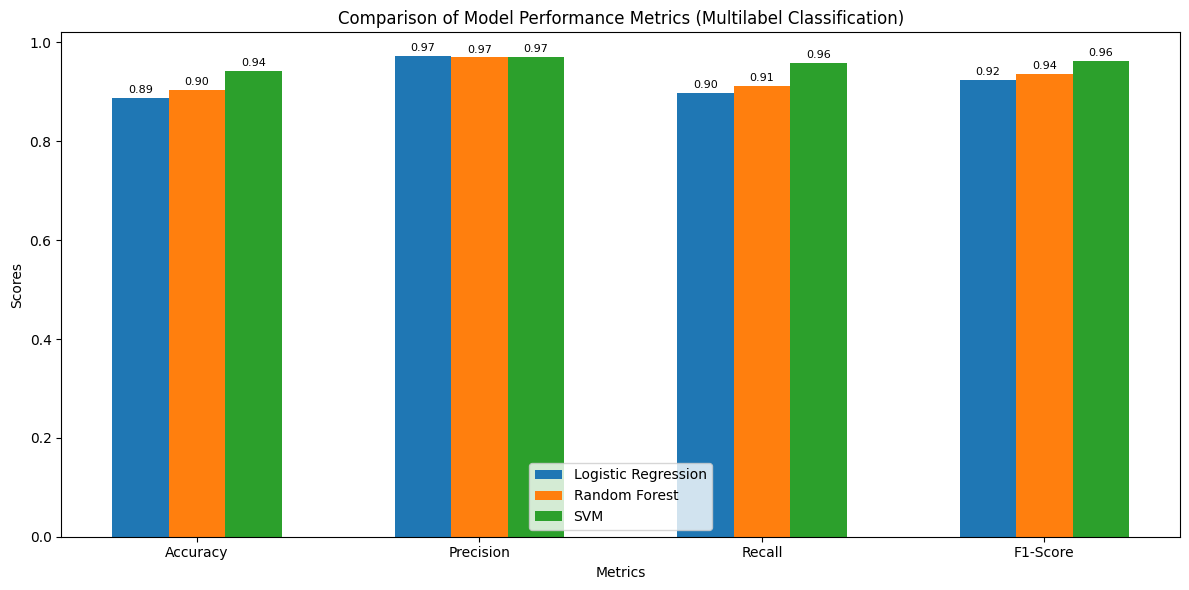

In [51]:
plot_model_metrics(results_df,"Multilabel Classification")

**SVM** stands out as the best-performing model overall, with the highest accuracy, recall, and F1-score. Its improvement is most evident in less frequent classes, which often pose greater challenges for classification models.

In [47]:
svm_model = trained_models["SVM"]

y_pred_bin = svm_model.predict(X_test_vec)

for i in range(50):
    binary_labels = y_pred_bin[i]
    predicted_labels = [mlb.classes_[j] for j, value in enumerate(binary_labels) if value == 1]
    print(f"Instance {i + 1}: {predicted_labels}")


Instance 1: ['money-fx']
Instance 2: []
Instance 3: ['money-fx']
Instance 4: []
Instance 5: ['interest']
Instance 6: []
Instance 7: ['interest']
Instance 8: ['ship']
Instance 9: ['acq']
Instance 10: ['acq']
Instance 11: ['interest', 'money-fx']
Instance 12: ['acq']
Instance 13: ['interest', 'money-fx']
Instance 14: ['money-fx']
Instance 15: ['money-fx']
Instance 16: ['money-fx']
Instance 17: ['money-fx']
Instance 18: ['money-fx']
Instance 19: []
Instance 20: ['money-fx']
Instance 21: ['money-fx']
Instance 22: ['ship']
Instance 23: ['ship']
Instance 24: ['ship']
Instance 25: ['earn']
Instance 26: ['earn']
Instance 27: ['acq']
Instance 28: ['earn']
Instance 29: ['earn']
Instance 30: ['earn']
Instance 31: ['earn']
Instance 32: ['earn']
Instance 33: ['earn']
Instance 34: ['acq']
Instance 35: ['earn']
Instance 36: ['earn']
Instance 37: ['acq']
Instance 38: ['interest']
Instance 39: ['earn']
Instance 40: ['interest']
Instance 41: ['interest']
Instance 42: ['earn']
Instance 43: ['earn']
Insta